In this notebook, we perform the perprocessing of the dataset "data-science-bootcamp/content/datasets/classification/raw/data_50.csv". The output of this notebook will be written in the folder "data-science-bootcamp/content/datasets/classification/processed" as four separated csv files: X_train.csv, X_test.csv, y_train.csv, y_test.csv. (These files will be used as input for the ML algorithms which are discussed in the next sessions of the bootcamp).

0. Eploratory Data Analysis (EDA)
1. Missing Value Imputation
2. Temporal variables
3. Categorical encoding
3.1. Label/Ordinal Encoding \
3.2. Count or frequency Encoding \ 
3.3. One Hot Encoding \
4. Handling Outliers
4.1. Identifying the outliers \
4.2. Outlier trimming \
4.3. Outlier Capping\
5. Feature Scaling
5.2. Standardization \
5.2. Min-Max Scaling\





# 0. Exploratory Data Analysis (EDA)

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option('display.max_columns', None) 
import warnings
warnings.filterwarnings('ignore')

### 0.1 Loading the data into a dataframe

In [2]:
# loading the "data_25.csv" into a dataframe called "df"
df= pd.read_csv('data_25_missing.csv', sep= ";", encoding= "utf-8")

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,female,university,married,24.0,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,female,university,single,26.0,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,female,university,single,34.0,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,female,university,married,37.0,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,male,university,married,57.0,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# drop the first column ("ID")
df.drop(columns=["ID"], axis=1, inplace= True)

In [5]:
# check the shape of the dataframe as a 2-dimensional data object (#rows, #columns)
df.shape

(30000, 24)

The dataset contains 30000 records (rows) and 24 columns (features + target):

The target column (y) is called "default payment next month".
The rest 23 columns (X) are our feature vectors.

In [6]:
df['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

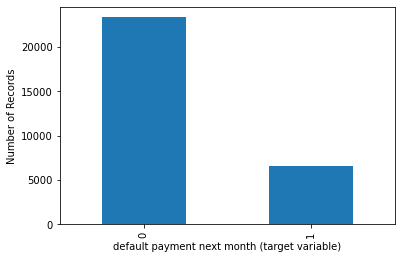

In [7]:
df['default payment next month'].value_counts().plot(kind="bar")
plt.ylabel("Number of Records")
plt.xlabel("default payment next month (target variable)")
plt.show()

The class distribution is imbalanced!

In [8]:
class_0 = df['default payment next month'].value_counts().to_list()[0]
class_1 = df['default payment next month'].value_counts().to_list()[1]

In [9]:
print("Imbalance ratio =", class_1/class_0)

Imbalance ratio = 0.2840267077555213


In [10]:
# We first have a look at the data types of all columns
df_type = pd.DataFrame(df.dtypes)
df_type

,0
LIMIT_BAL,int64
SEX,object
EDUCATION,object
MARRIAGE,object
AGE,float64
PAY_0,int64
PAY_2,int64
PAY_3,int64
PAY_4,int64
PAY_5,int64


In [11]:
# classifying columns with different data types:
str_cols = []
for col, dtype in df.dtypes.to_dict().items():
    if str(dtype) in 'object':
        str_cols.append(col)

print("Number of String Columns:", len(str_cols))

int_cols = []
for col, dtype in df.dtypes.to_dict().items():
    if str(dtype) in 'int64':
        int_cols.append(col)
print("Number of Integer Columns:", len(int_cols))

Number of String Columns: 3
Number of Integer Columns: 20


# 1. Missing Value Imputation

### 1.0. Identifying columns with null values

In [12]:
null_cols = [col for col in df.columns if df[col].isnull().mean() > 0] 

In [13]:
print(null_cols)

['EDUCATION', 'MARRIAGE', 'AGE']


In [14]:
print("Number of Columns with Null values:", len(null_cols))
print("Percentage of null values:")
for col in null_cols:
    print(col, round(df[col].isnull().mean(), 4), ", Data Type: ", df[col].dtype)

Number of Columns with Null values: 3
Percentage of null values:
EDUCATION 0.0115 , Data Type:  object
MARRIAGE 0.0018 , Data Type:  object
AGE 0.0187 , Data Type:  float64


We observe that "EDUCATION" and "AGE" have less than 2% missing values and "MARRIAGE" has 0.18% missing value.\
For the column "MARRIAGE", we perform Complete Case Analysis,\
For the integer column "AGE", we perform mean/median imputation, \
For the categorical column "EDUCATION", we perform Frequent Category Imputation.

## 1.1. Complete Case Analysis

In [15]:
df = df.dropna(subset=["MARRIAGE"],  axis=0) 
df.shape

(29946, 24)

We observe that after dropping the missing values, the number of records is reduced from 30000 to 29946.

## 1.2. Mean or Median Imputation: fillna()

Before filling the null values, we split the data into train and test sets

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df['default payment next month'], test_size=0.3, random_state=10)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20962, 24), (8984, 24), (20962,), (8984,))

In [17]:
y_train_class_0 = y_train.value_counts().to_list()[0]
y_train_class_1 = y_train.value_counts().to_list()[1]

In [18]:
print("Imbalance ratio y_train =", y_train_class_1/y_train_class_0)

Imbalance ratio y_train = 0.28364972443355785


In [19]:
X_train_class_0 = X_train["default payment next month"].value_counts().to_list()[0]
X_train_class_1 = X_train["default payment next month"].value_counts().to_list()[1]
print("Imbalance ratio X_train =", X_train_class_1/X_train_class_0)

Imbalance ratio X_train = 0.28364972443355785


Before deciding whether we implement the mean or median imputation, we plot the distribution of "AGE" 

<AxesSubplot:>

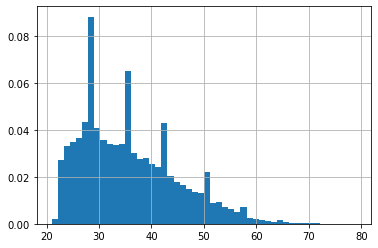

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
df['AGE'].hist(bins=50, ax=ax, density=True)

In [21]:
print("Mean of AGE: ", df['AGE'].mean())
print("Median of AGE: ", df['AGE'].median())
print("Mode of AGE: ", df['AGE'].mode())

Mean of AGE:  35.738208670795615
Median of AGE:  34.0
Mode of AGE:  0    29.0
dtype: float64


Since the data distribution is skewed, we perform median imputation

In [22]:
AGE_median = X_train['AGE'].median()
X_train['AGE_median'] = X_train['AGE'].fillna(AGE_median)
X_test['AGE_median'] = X_test['AGE'].fillna(AGE_median)

<AxesSubplot:>

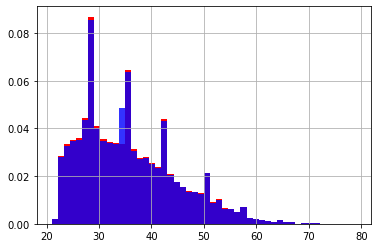

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['AGE'].hist(bins=50, ax=ax, density=True, color='red')
X_train['AGE_median'].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.8)

## 1.3. Frequent Category Imputation (Mode Imputation)

TODO: PLOT ALL DIAGRAMS IN ONE 

<AxesSubplot:>

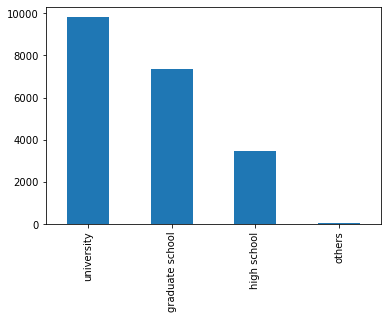

In [24]:
X_train['EDUCATION'].value_counts().sort_values(ascending=False).plot.bar()

In [25]:
EDUCATION_MODE = X_train["EDUCATION"].mode()[0]             
EDUCATION_MODE               

'university'

In [26]:
X_train['EDUCATION'].fillna(EDUCATION_MODE, inplace=True)
X_test['EDUCATION'].fillna(EDUCATION_MODE, inplace=True)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20962, 25), (8984, 25), (20962,), (8984,))

# 3. Categorical encoding

In [28]:
# Recall that we have 3 categorical columns
print(str_cols)

['SEX', 'EDUCATION', 'MARRIAGE']


In [29]:
for col in str_cols:
    print(col, X_train[col].unique())

SEX ['female' 'male']
EDUCATION ['graduate school' 'university' 'high school' 'others']
MARRIAGE ['married' 'single' 'others']


One Hot Encoding (using Scikit-Learn)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20962, 25), (8984, 25), (20962,), (8984,))

In [31]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse= False, handle_unknown='ignore')
encoder.fit(X_train[str_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [32]:
# transform the catogorical columns in X_train
X_train_transformed = encoder.transform(X_train[str_cols])
# turn the transformed Numpy array into a Pandas dataframe
X_train_OHE_skl = pd.DataFrame(X_train_transformed)

In [33]:
X_train_OHE_skl

,0,1,2,3,4,5,6,7,8
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
20957,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
20958,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
20959,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
20960,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [34]:
# as we can see, the new encoded columns are named as integers. 
# However, the names of the features are stored in the get_feature_names() method
encoder.get_feature_names()

array(['x0_female', 'x0_male', 'x1_graduate school', 'x1_high school',
       'x1_others', 'x1_university', 'x2_married', 'x2_others',
       'x2_single'], dtype=object)

In [35]:
# we rename the dataframe columns to the above names
X_train_OHE_skl.columns = encoder.get_feature_names()

In [36]:
X_train_OHE_skl.head()

,x0_female,x0_male,x1_graduate school,x1_high school,x1_others,x1_university,x2_married,x2_others,x2_single
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [37]:
# transform the catogorical columns in X_test
X_test_transformed = encoder.transform(X_test[str_cols])
# turned the transformed Numpy array into a Pandas dataframe
X_test_OHE_skl = pd.DataFrame(X_test_transformed)
# rename the new encoded  columns 
X_test_OHE_skl.columns = encoder.get_feature_names()

In [38]:
X_train_OHE_skl.shape, X_test_OHE_skl.shape

((20962, 9), (8984, 9))

We now concatinate the original X_train/X_test and the encoded X_train_OHE_skl/X_test_OHE_skl (and then drop the categorical columns from the resulting dataframe). 

In [39]:
X_train = pd.concat([X_train.reset_index(drop=True), X_train_OHE_skl.reset_index(drop=True)], axis=1)
X_train = X_train.drop(columns=str_cols, axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_OHE_skl.reset_index(drop=True)], axis=1)
X_test = X_test.drop(columns=str_cols, axis=1)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20962, 31), (8984, 31), (20962,), (8984,))

# 4. Handling Outliers
4.1. Identifying the outliers \
4.2. Outlier trimming \
4.3. Outlier Capping


## 4.1. Identifying the outliers

In [41]:
print(int_cols)

['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


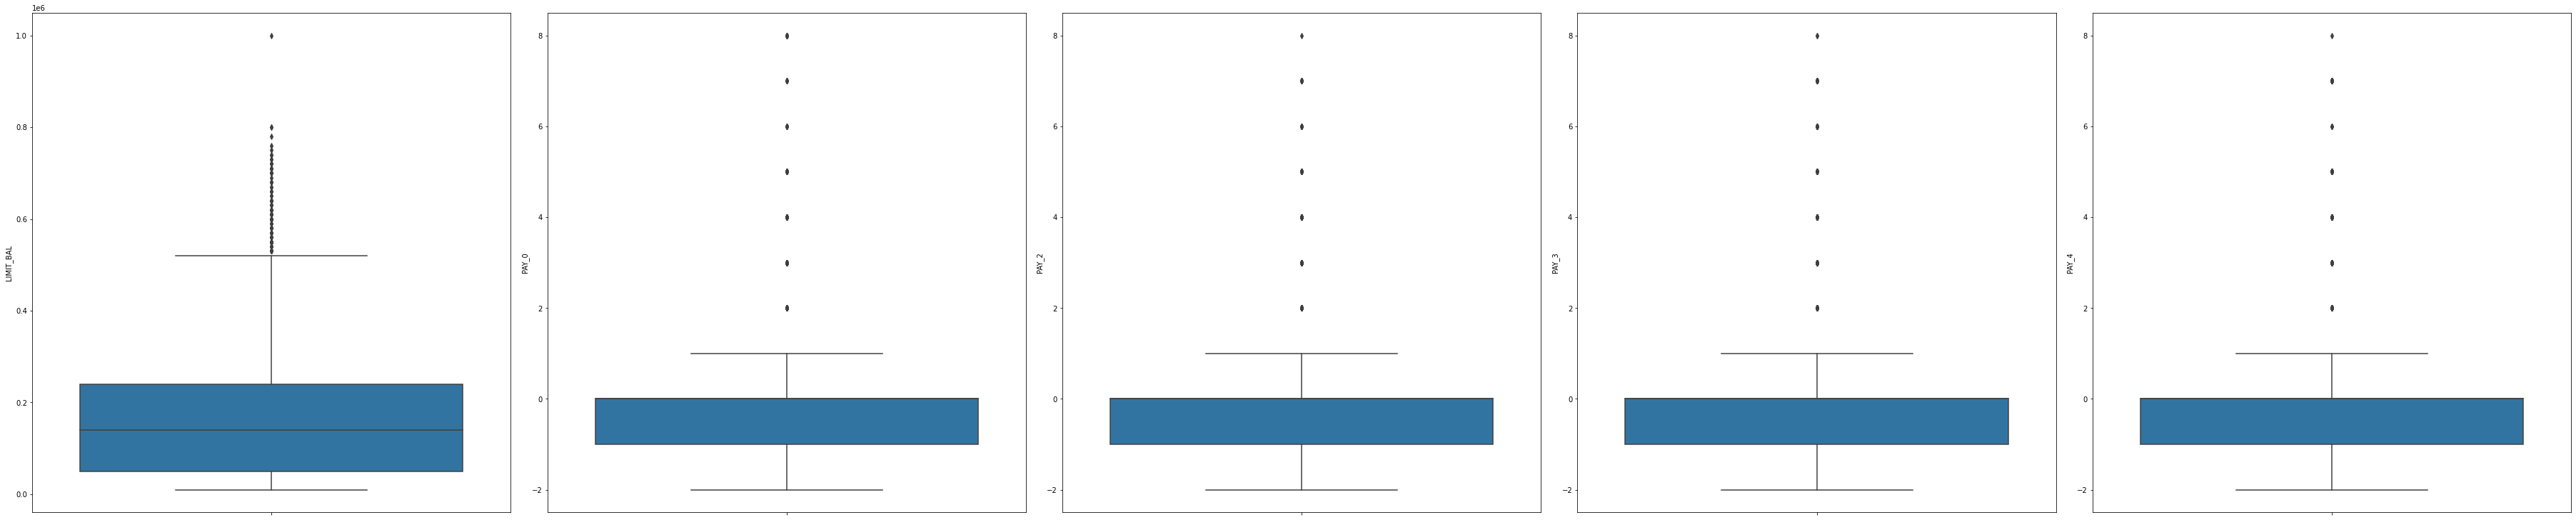

In [42]:
plt.rcParams["figure.figsize"] = (50,10)
fig, axs = plt.subplots(ncols=5, constrained_layout=True)
sns.boxplot(y=X_train['LIMIT_BAL'], ax=axs[0])
sns.boxplot(y=X_train['PAY_0'], ax=axs[1])
sns.boxplot(y=X_train['PAY_2'], ax=axs[2])
sns.boxplot(y=X_train['PAY_3'], ax=axs[3])
sns.boxplot(y=X_train['PAY_4'], ax=axs[4])
plt.show()


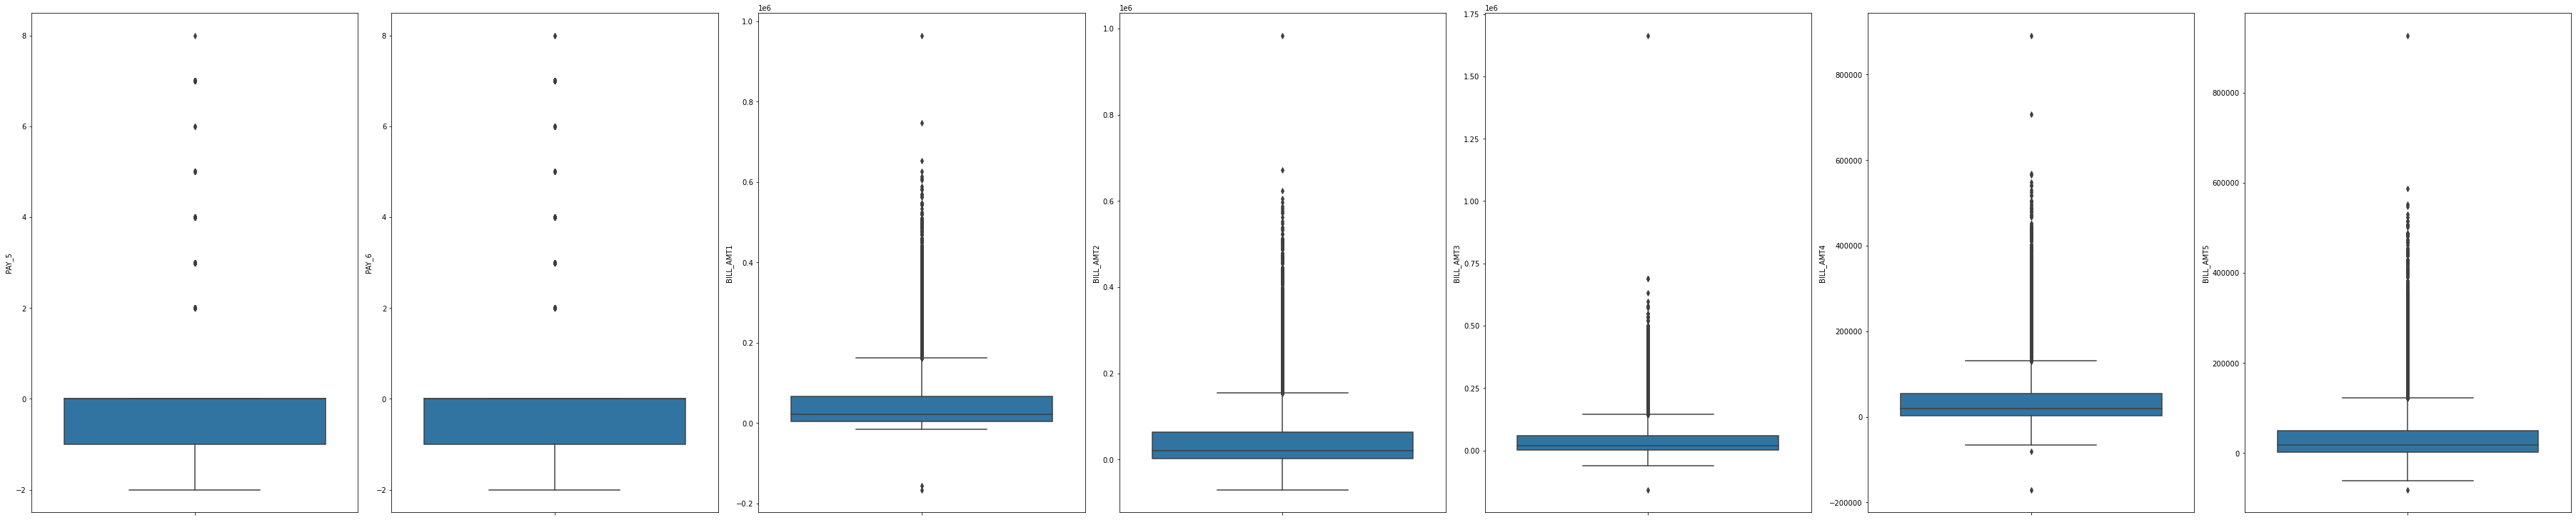

In [43]:
fig, axs = plt.subplots(ncols=7, constrained_layout=True)
sns.boxplot(y=X_train['PAY_5'], ax=axs[0])
sns.boxplot(y=X_train['PAY_6'], ax=axs[1])
sns.boxplot(y=X_train['BILL_AMT1'], ax=axs[2])
sns.boxplot(y=X_train['BILL_AMT2'], ax=axs[3])
sns.boxplot(y=X_train['BILL_AMT3'], ax=axs[4])
sns.boxplot(y=X_train['BILL_AMT4'], ax=axs[5])
sns.boxplot(y=X_train['BILL_AMT5'], ax=axs[6])
plt.rcParams["figure.figsize"] = (50,10)
plt.show()

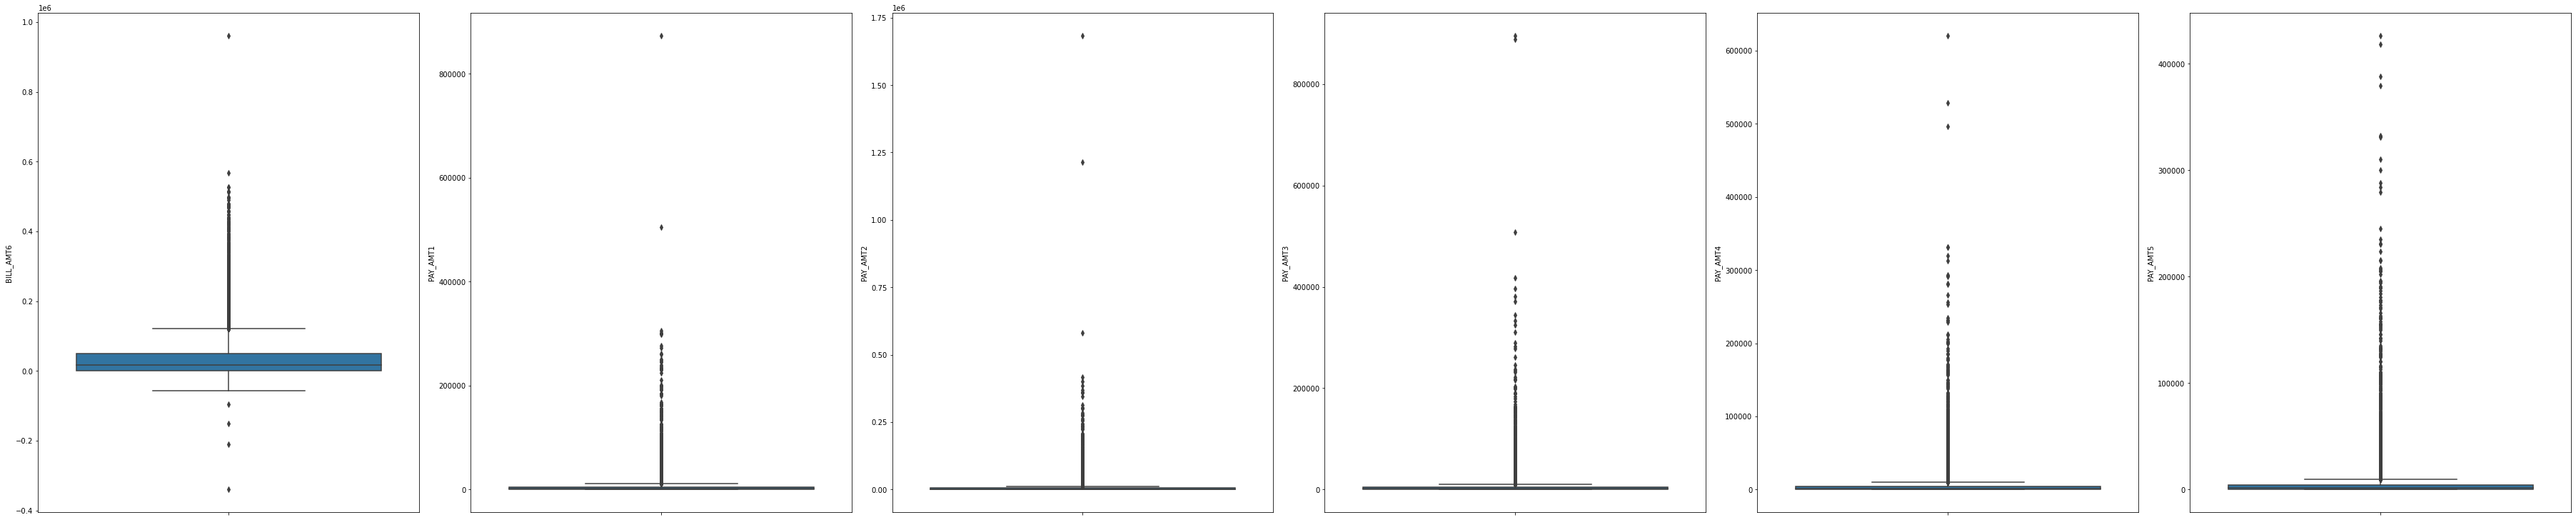

In [44]:
fig, axs = plt.subplots(ncols=6, constrained_layout=True)
sns.boxplot(y=X_train['BILL_AMT6'], ax=axs[0])
sns.boxplot(y=X_train['PAY_AMT1'], ax=axs[1])
sns.boxplot(y=X_train['PAY_AMT2'], ax=axs[2])
sns.boxplot(y=X_train['PAY_AMT3'], ax=axs[3])
sns.boxplot(y=X_train['PAY_AMT4'], ax=axs[4])
sns.boxplot(y=X_train['PAY_AMT5'], ax=axs[5])
plt.rcParams["figure.figsize"] = (50,10)
plt.show()

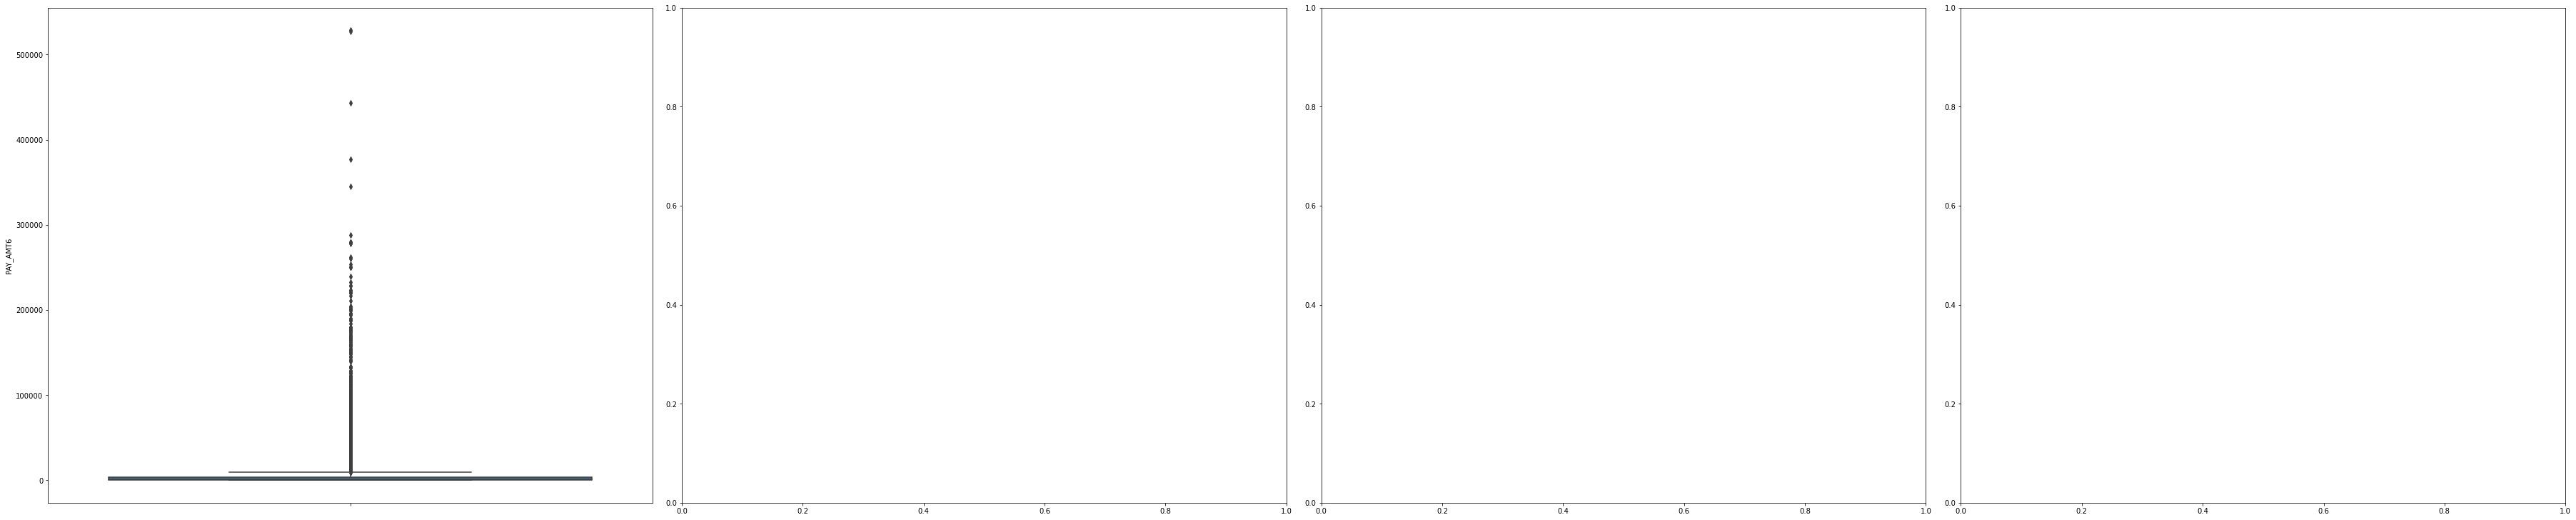

In [45]:
fig, axs = plt.subplots(ncols=4, constrained_layout=True)
sns.boxplot(y=X_train['PAY_AMT6'], ax=axs[0])
plt.rcParams["figure.figsize"] = (50,10)
plt.show()

The above result confirms our observation from the boxplots. Now we create a list of all columns which contain outliers.

In [46]:
# Now we repeat the same steps for all the columns with outliers
# We first create the following dictionaries
IRQ_dict= {}
for col in X_train.columns:
    IRQ_dict[f"{col}_IQR"] = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)

lower_boundary_dict= {}
for col in X_train.columns:
    lower_boundary_dict[f"{col}_lower_boundary"] = X_train[col].quantile(0.25) - (IRQ_dict[f"{col}_IQR"] * 1.6)

upper_boundary_dict= {}
for col in X_train.columns:
    upper_boundary_dict[f"{col}_upper_boundary"] = X_train[col].quantile(0.25) + (IRQ_dict[f"{col}_IQR"] * 1.6)

columns_outliers_dict={}
for col in X_train.columns:
    columns_outliers_dict[f"{col}_outliers_list"] = np.where(X_train[col] > upper_boundary_dict[f"{col}_upper_boundary"], True,
                       np.where(X_train[col] < lower_boundary_dict[f"{col}_lower_boundary"], True, False))

In [47]:
print(" >>IRQ_dict: ", IRQ_dict)
print(" >>lower_boundary_dict: ", lower_boundary_dict)
print(" >>upper_boundary_dict: ", upper_boundary_dict)

 >>IRQ_dict:  {'LIMIT_BAL_IQR': 190000.0, 'AGE_IQR': 14.0, 'PAY_0_IQR': 1.0, 'PAY_2_IQR': 1.0, 'PAY_3_IQR': 1.0, 'PAY_4_IQR': 1.0, 'PAY_5_IQR': 1.0, 'PAY_6_IQR': 1.0, 'BILL_AMT1_IQR': 63464.25, 'BILL_AMT2_IQR': 60431.0, 'BILL_AMT3_IQR': 56922.0, 'BILL_AMT4_IQR': 51607.0, 'BILL_AMT5_IQR': 48246.75, 'BILL_AMT6_IQR': 48052.75, 'PAY_AMT1_IQR': 4005.0, 'PAY_AMT2_IQR': 4196.25, 'PAY_AMT3_IQR': 4144.5, 'PAY_AMT4_IQR': 3739.0, 'PAY_AMT5_IQR': 3804.5, 'PAY_AMT6_IQR': 3907.5, 'default payment next month_IQR': 0.0, 'AGE_median_IQR': 13.0, 'x0_female_IQR': 1.0, 'x0_male_IQR': 1.0, 'x1_graduate school_IQR': 1.0, 'x1_high school_IQR': 0.0, 'x1_others_IQR': 0.0, 'x1_university_IQR': 1.0, 'x2_married_IQR': 1.0, 'x2_others_IQR': 0.0, 'x2_single_IQR': 1.0}
 >>lower_boundary_dict:  {'LIMIT_BAL_lower_boundary': -254000.0, 'AGE_lower_boundary': 5.599999999999998, 'PAY_0_lower_boundary': -2.6, 'PAY_2_lower_boundary': -2.6, 'PAY_3_lower_boundary': -2.6, 'PAY_4_lower_boundary': -2.6, 'PAY_5_lower_boundary': -

In [48]:
for col in X_train.columns:
    print(f"Percentage of outliers in {col}: ", columns_outliers_dict[f"{col}_outliers_list"].mean())

Percentage of outliers in LIMIT_BAL:  0.11101039977101422
Percentage of outliers in AGE:  0.07494513882263143
Percentage of outliers in PAY_0:  0.22960595363037878
Percentage of outliers in PAY_2:  0.1485545272397672
Percentage of outliers in PAY_3:  0.14235282892853734
Percentage of outliers in PAY_4:  0.11845243774449003
Percentage of outliers in PAY_5:  0.10113538784467131
Percentage of outliers in PAY_6:  0.10380688865566262
Percentage of outliers in BILL_AMT1:  0.15289571605762808
Percentage of outliers in BILL_AMT2:  0.15475622555099705
Percentage of outliers in BILL_AMT3:  0.1574754317336132
Percentage of outliers in BILL_AMT4:  0.16133956683522566
Percentage of outliers in BILL_AMT5:  0.1645835321057151
Percentage of outliers in BILL_AMT6:  0.1632000763285946
Percentage of outliers in PAY_AMT1:  0.16410647838946665
Percentage of outliers in PAY_AMT2:  0.15456540406449767
Percentage of outliers in PAY_AMT3:  0.14764812517889514
Percentage of outliers in PAY_AMT4:  0.151750787138

In [49]:
outlier_cols = [col for col in X_train.columns if  columns_outliers_dict[f"{col}_outliers_list"].mean() > 0 ] 
print(outlier_cols)

['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month', 'AGE_median', 'x1_high school', 'x1_others', 'x2_others']


## 4.2. Outlier trimming
Drop all the records which include an outlier (in X_train)

In [50]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20962, 31), (20962,), (8984, 31), (8984,))

In [51]:
# we implement the outlier trimming method for outlier_10percent_cols
#create a list of columns with less than 10% outliers
outlier_10percent_cols = [col for col in outlier_cols if columns_outliers_dict[f"{col}_outliers_list"].mean() < 0.1 ] 

print(outlier_10percent_cols)

['AGE', 'x1_others', 'x2_others']


In [52]:
X_train = X_train.loc[~(
+ columns_outliers_dict["AGE_outliers_list"]
+ columns_outliers_dict["x1_others_outliers_list"]
+ columns_outliers_dict["x2_others_outliers_list"]
), 
]

In [53]:
y_train = y_train.loc[~(
+ columns_outliers_dict["AGE_outliers_list"]
+ columns_outliers_dict["x1_others_outliers_list"]
+ columns_outliers_dict["x2_others_outliers_list"]
), 
]

In [54]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((19141, 31), (8984, 31), (19141,), (8984,))

The outlier trimming procedure has reduced the 20962 records in X_train/y_train to 19141 records.\
We also need to check if the Imbalance ration is changed.

In [55]:
X_train_class_0 = X_train["default payment next month"].value_counts().to_list()[0]
X_train_class_1 = X_train["default payment next month"].value_counts().to_list()[1]
print("Imbalance ratio X_train =", X_train_class_1/X_train_class_0)

Imbalance ratio X_train = 0.280934216690089


## 4.2. Outlier Capping
TODO: explanations!

In [56]:
# we create a set of the columns with more than 1 percent outliers
outlier_90percent_cols = list(set(X_train.columns) - set(outlier_10percent_cols)) 

In [57]:
print(outlier_90percent_cols)

['PAY_AMT6', 'PAY_0', 'x1_graduate school', 'PAY_AMT1', 'AGE_median', 'x1_university', 'BILL_AMT1', 'x2_single', 'PAY_5', 'PAY_6', 'BILL_AMT3', 'BILL_AMT5', 'PAY_AMT3', 'BILL_AMT4', 'x2_married', 'x0_female', 'BILL_AMT6', 'PAY_AMT2', 'LIMIT_BAL', 'PAY_AMT5', 'PAY_2', 'PAY_4', 'x0_male', 'default payment next month', 'PAY_AMT4', 'PAY_3', 'BILL_AMT2', 'x1_high school']


In [58]:
for col in outlier_90percent_cols:
    X_train[col] = np.where(X_train[col] > upper_boundary_dict[f"{col}_upper_boundary"], upper_boundary_dict[f"{col}_upper_boundary"],
                         np.where(X_train[col] < lower_boundary_dict[f"{col}_lower_boundary"], lower_boundary_dict[f"{col}_lower_boundary"], X_train[col]))

In [59]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((19141, 31), (8984, 31), (19141,), (8984,))

We observe that outlier capping does not reduce the dataset size.

# 5. Feature Scaling

Before performing feature scaling, we drop the target column from X_train.

In [60]:
X_train.drop(columns=["default payment next month"], inplace= True)
X_test.drop(columns=["default payment next month"], inplace= True)

In [61]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((19141, 30), (8984, 30), (19141,), (8984,))

### 5.2. Min-Max Scaling

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Feature Selection
6.1. Dropping Constant Features \
6.2. Correlation-based Feature Selection\
6.2.a Selecting Features with low correlations with other features\
6.2.a Selecting Features with hight correlations with Target

### 6.1. Dropping Constant Features

In [63]:
const_feat = [X for X in X_train.columns if X_train[X].nunique() == 1]
const_feat

['x1_high school', 'x1_others', 'x2_others']

In [64]:
X_train.drop(labels=const_feat, axis=1, inplace= True)
X_test.drop(labels=const_feat, axis=1, inplace= True)

In [65]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((19141, 27), (8984, 27), (19141,), (8984,))

### 6.2. Correlation-based Feature Selection

### 6.2.a Selecting Features with hight correlations with Target

In [66]:
# We first add the target (y_train) to the Features (X_train) to be able to calculate the correlation matrix between them
df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis = 1)
# create the correlation matrix
cor_mat = df_train.corr()
# Add a column which containes the sorted absolute values of corr(X_train, y_train)
cor_mat["X-Y_corr"]= cor_mat["default payment next month"].abs().sort_values(ascending=False) 

In [67]:
cor_mat["X-Y_corr"]

LIMIT_BAL                     0.157349
AGE                           0.008035
PAY_0                         0.210598
PAY_2                         0.164235
PAY_3                         0.149419
PAY_4                         0.131824
PAY_5                         0.120250
PAY_6                         0.110963
BILL_AMT1                     0.024606
BILL_AMT2                     0.017476
BILL_AMT3                     0.015716
BILL_AMT4                     0.010190
BILL_AMT5                     0.008320
BILL_AMT6                     0.001740
PAY_AMT1                      0.141378
PAY_AMT2                      0.140700
PAY_AMT3                      0.127861
PAY_AMT4                      0.117183
PAY_AMT5                      0.107475
PAY_AMT6                      0.116103
AGE_median                    0.007808
x0_female                     0.037545
x0_male                       0.037545
x1_graduate school            0.057374
x1_university                 0.029199
x2_married               

In [68]:
# collect all the features with corr(X_train, y_train) > 0.01 into a list
final_cols = cor_mat[cor_mat["X-Y_corr"] > 0.01].index.values.tolist()
final_cols = list(set(final_cols) - set(["default payment next month"]))

In [69]:
len(final_cols)

23

In [70]:
X_train = X_train[final_cols]
X_test = X_test[final_cols]

In [71]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19141, 23), (19141,), (8984, 23), (8984,))

### 6.2.b Selecting Features with low correlations with other features

<AxesSubplot:>

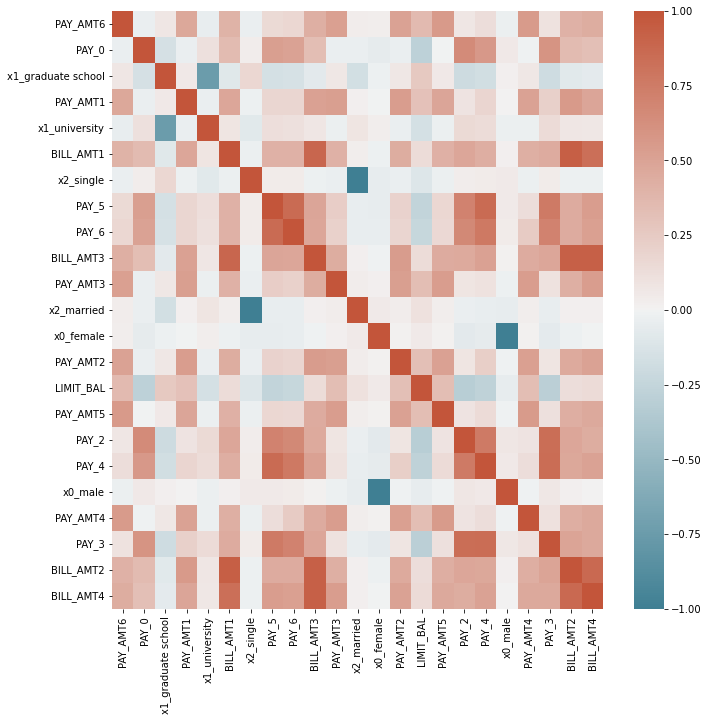

In [72]:
corrmat = X_train.corr(method='pearson')

cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots()
fig.set_size_inches(11,11)

sns.heatmap(corrmat, cmap=cmap)

In [73]:
col_corr = set()
corr_matrix = X_train.corr()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: 
            print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
            colname = corr_matrix.columns[j]
            col_corr.add(colname)

1.0000000000000002 x2_married x2_single
0.9999999999999998 x0_male x0_female
0.9359599283033919 BILL_AMT2 BILL_AMT1
0.9288389488314095 BILL_AMT2 BILL_AMT3
0.9225206806190829 BILL_AMT4 BILL_AMT3


In [74]:
X_train.drop(labels=col_corr, axis=1, inplace=True)
X_test.drop(labels=col_corr, axis=1, inplace=True)

In [75]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19141, 19), (19141,), (8984, 19), (8984,))

## 7. Saving the preprocessed data

In [76]:
pd.DataFrame(X_train).to_csv("x_train.csv", index=None)
pd.DataFrame(X_test).to_csv("x_test.csv", index=None)

pd.DataFrame(y_train).to_csv("y_train.csv", index=None)
pd.DataFrame(y_test).to_csv("y_test.csv", index=None)